## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №26

#### Прогноз просрочки кредита заемщиком

Необходимо решить задачу просрочки кредита используя для прогназирования нейронные сети. Рассмотреть работу с несбалансированными данными.  

Набор данных представляет собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ).  
Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from math import nan

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42

# Функция генерации файла результатов
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [2]:
df = pd.read_csv('cs-training.csv', index_col=0)

col_dict = {
    # Целевая метка (1/0): будет ли просрочка платежей более 90 дней в ближайшие 2 года, Да/Нет
    'SeriousDlqin2yrs':'Delinquency',  
    # Баланс по кредитам (%): сумма всех кредитов за исключением недвижимости и рассрочек(автокредиты), разделенная на сумму кредитных лимитов
    'RevolvingUtilizationOfUnsecuredLines':'CreditBalance',
    # Возраст заемщика (лет)
    'age':'Age',
    # Количество просрочек платежей за последние 2 года: от 30 до 59 дней
    'NumberOfTime30-59DaysPastDueNotWorse':'Delay30_59',
    # Коэффициент задолженности (%): отношение суммы ежемесячных платежей (долги, алименты, проживание) к месячному доходу
    'DebtRatio':'DebtRatio',
    # Mесячный доход ($)
    'MonthlyIncome':'MonthlyIncome',
    # Количество открытых кредитов (рассрочек) и кредитных линий (кредитные карты)
    'NumberOfOpenCreditLinesAndLoans':'CreditLineNum',
    # Количество просрочек платежей за последние 2 года: 90 дней и больше
    'NumberOfTimes90DaysLate':'Delay90',
    # Количество открытых кредитов на недвижимость, включая кредитные линии под залог жилья
    'NumberRealEstateLoansOrLines':'EstateLoanNum',
    # Количество просрочек платежей за последние 2 года: от 60 до 89 дней
    'NumberOfTime60-89DaysPastDueNotWorse':'Delay60_89',
    # Количество иждивенцев в семье (исключая заемщика)
    'NumberOfDependents':'Dependents'
} 

df.columns = [col_dict.get(x,x) for x in df.columns]

df = df[['Age','Dependents','MonthlyIncome','DebtRatio','CreditBalance','CreditLineNum','EstateLoanNum','Delay30_59','Delay60_89','Delay90','Delinquency']]

Проверить наличие NaN в значениях признаков, при необходимости осуществить замену  
Выполнить удаление дубликатов

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Age            150000 non-null  int64  
 1   Dependents     146076 non-null  float64
 2   MonthlyIncome  120269 non-null  float64
 3   DebtRatio      150000 non-null  float64
 4   CreditBalance  150000 non-null  float64
 5   CreditLineNum  150000 non-null  int64  
 6   EstateLoanNum  150000 non-null  int64  
 7   Delay30_59     150000 non-null  int64  
 8   Delay60_89     150000 non-null  int64  
 9   Delay90        150000 non-null  int64  
 10  Delinquency    150000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [3]:
# Для признака Dependents заменить все пустые значения на -1
df['Dependents'].fillna(-1, inplace=True)
# Для признака MonthlyIncome заменить все пустые значения на 0
df['MonthlyIncome'].fillna(0, inplace=True)

print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

# Удалить дубликаты сохраняя первую запись
df = df.drop_duplicates(keep='first')
print(f'Набор данных после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 648
Набор данных после удаления дубликатов: (149352, 11)


Построить корреляционную матрицу признаков  
Проанализировать зависимости

<AxesSubplot: >

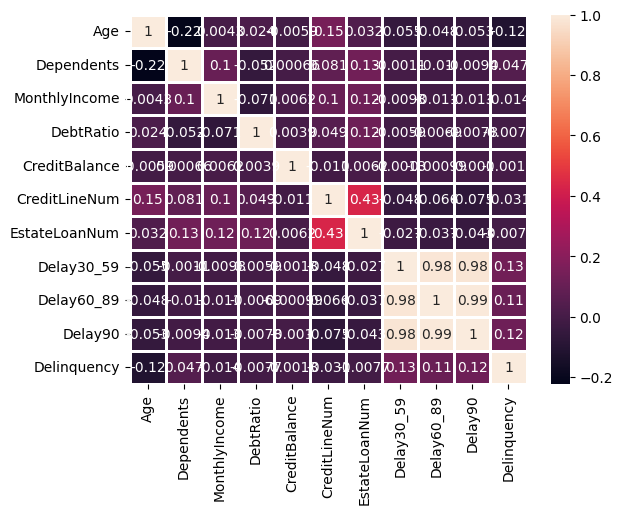

In [5]:
sns.heatmap(df.corr(), annot=True, linewidths=1)

- Наблюдается незначительная отрицательная корреляция (-0.22) признаков возраста (Age) и количества иждивенцев (Dependents)
- Наблюдается существенная положительная корреляция (0.43) между собой признаков количества открытых кредитов (CreditLineNum и EstateLoanNum)
- Наблюдается сильная корреляция (0.98 - 0.99) между собой признаков наличия просрочек платежей за различные периоды (Delay30_59, Delay60_89, Delay90)

In [4]:
# Заменить признаки CreditLineNum и EstateLoanNum на суммарный признак CreditNum
df.insert(7,'CreditNum', df.CreditLineNum + df.EstateLoanNum)
df.drop(['CreditLineNum','EstateLoanNum'], axis=1, inplace=True)

# Заменить признаки Delay30_59, Delay60_89 и Delay90 на суммарный признак DelayNum
df.insert(9,'DelayNum', df.Delay30_59 + df.Delay60_89 + df.Delay90)
df.drop(['Delay30_59','Delay60_89','Delay90'], axis=1, inplace=True)

In [7]:
# Визуализировать распределение значений признаков
df.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
Age,149352.0,52.310153,14.722797,0.0,41.000000,52.000000,63.000000,109.0
Dependents,149352.0,0.714935,1.136387,-1.0,0.000000,0.000000,1.000000,20.0
MonthlyIncome,149352.0,5370.845780,13176.007265,0.0,1600.000000,4400.000000,7400.000000,3008750.0
DebtRatio,149352.0,354.529267,2042.102001,0.0,0.177571,0.368293,0.875665,329664.0
CreditBalance,149352.0,6.072551,250.296329,0.0,0.030150,0.154239,0.556414,50708.0
CreditNum,149352.0,9.505444,5.714916,0.0,5.000000,9.000000,13.000000,112.0
DelayNum,149352.0,0.840792,11.384862,0.0,0.000000,0.000000,0.000000,294.0
Delinquency,149352.0,0.067009,0.250039,0.0,0.000000,0.000000,0.000000,1.0


Визуализировать аномальные значения признаков

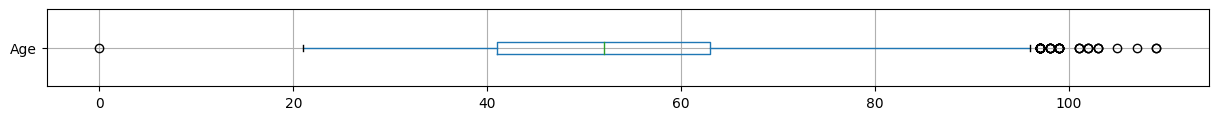

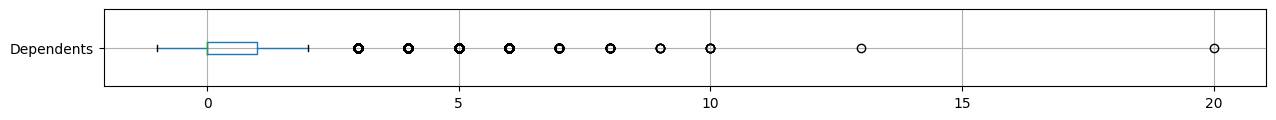

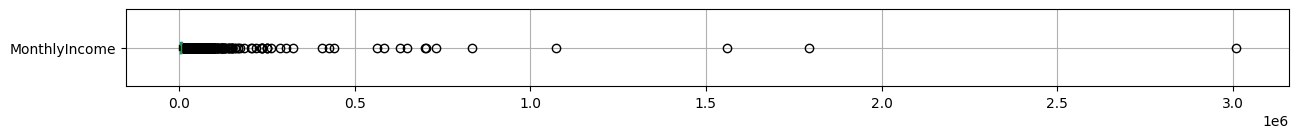

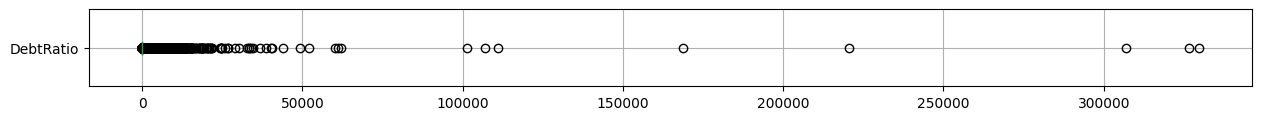

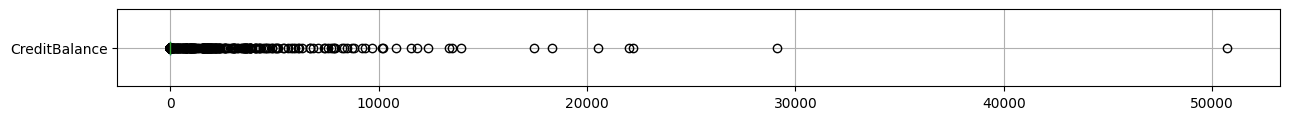

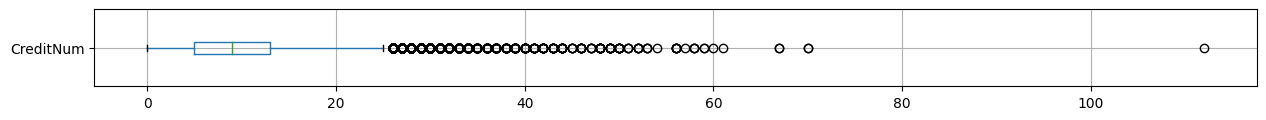

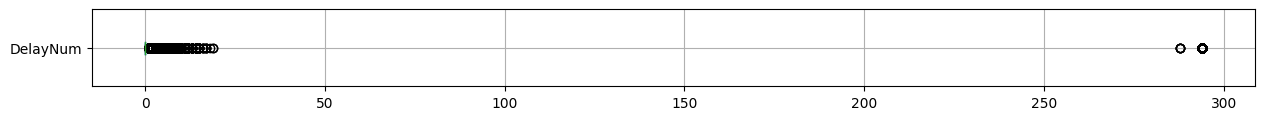

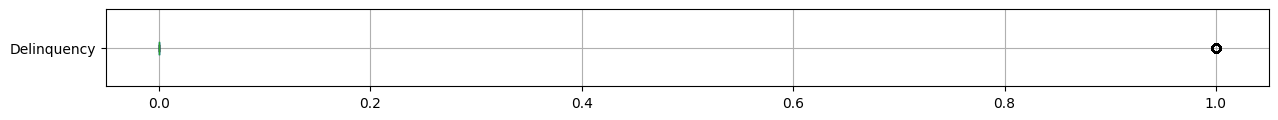

In [8]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df[[col]].boxplot(vert=0 )

In [9]:
# Заменить нулевые значения возраста медианным значением
df['Age'].replace(0, df['Age'].median(), inplace=True) 

# Удалить записи с аномальными значениями признаков
df.drop(df[df.Dependents > 15].index, inplace=True)
df.drop(df[df.MonthlyIncome > 200000.0].index, inplace=True)
df.drop(df[df.DebtRatio > 22000.0].index, inplace=True)
df.drop(df[df.CreditBalance > 8000.0].index, inplace=True)
df.drop(df[df.CreditNum > 55].index, inplace=True)
df.drop(df[df.DelayNum > 50].index, inplace=True)

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [11]:
# Подсчитать количество уникальных значений по столбцам
df.nunique(axis=0)

Age                  85
Dependents           13
MonthlyIncome     13560
DebtRatio        114075
CreditBalance    125638
CreditNum            55
DelayNum             20
Delinquency           2
dtype: int64

In [5]:
# Добавить признак категории возраста
df.insert(1,'AgeCategory', 'unknown')
df.loc[(df.Age>0) & (df.Age<=44), 'AgeCategory'] = 'young' 
df.loc[(df.Age>44) & (df.Age<=59), 'AgeCategory'] = 'average' 
df.loc[(df.Age>59) & (df.Age<=74), 'AgeCategory'] = 'elderly' 
df.loc[(df.Age>74), 'AgeCategory'] = 'senile' 

df['AgeCategory'].value_counts()

average    53784
young      47501
elderly    36812
senile     11254
unknown        1
Name: AgeCategory, dtype: int64

In [6]:
# Добавить признак категории количества иждивенцев
df.insert(3,'DepCategory', 'unknown')
df['DepCategory'] = np.where((df.Dependents>=0) & (df.Dependents<=5), df.Dependents, 'unknown')
df.loc[df.Dependents>5, 'DepCategory'] = 'horde' 

df['DepCategory'].value_counts()

0.0        86355
1.0        26313
2.0        19520
3.0         9483
unknown     3828
4.0         2862
5.0          746
horde        245
Name: DepCategory, dtype: int64

In [7]:
# Добавить признак категории месячного дохода
df.insert(5,'IncomeCategory', 'unknown')
df.loc[(df.MonthlyIncome>0) & (df.MonthlyIncome<=3000), 'IncomeCategory'] = 'upto3000' 
df.loc[(df.MonthlyIncome>3000) & (df.MonthlyIncome<=5000), 'IncomeCategory'] = 'upto5000' 
df.loc[(df.MonthlyIncome>5000) & (df.MonthlyIncome<=7500), 'IncomeCategory'] = 'upto7500' 
df.loc[(df.MonthlyIncome>7500) & (df.MonthlyIncome<=10000), 'IncomeCategory'] = 'upto10000' 
df.loc[(df.MonthlyIncome>10000) & (df.MonthlyIncome<=20000), 'IncomeCategory'] = 'upto20000' 
df.loc[(df.MonthlyIncome>20000), 'IncomeCategory'] = 'ScroogeMcDuck'

df['IncomeCategory'].value_counts()

unknown          30798
upto5000         30773
upto7500         28657
upto3000         23371
upto10000        17434
upto20000        16216
ScroogeMcDuck     2103
Name: IncomeCategory, dtype: int64

In [8]:
# Добавить признак категории количества открытых кредитов
df.insert(9,'CreditNumCategory', 'unknown')
df.loc[(df.CreditNum>0) & (df.CreditNum<=4), 'CreditNumCategory'] = 'easy' 
df.loc[(df.CreditNum>4) & (df.CreditNum<=7), 'CreditNumCategory'] = 'ligth' 
df.loc[(df.CreditNum>7) & (df.CreditNum<=10), 'CreditNumCategory'] = 'average' 
df.loc[(df.CreditNum>10) & (df.CreditNum<=15), 'CreditNumCategory'] = 'hard' 
df.loc[(df.CreditNum>15), 'CreditNumCategory'] = 'extreme' 

df['CreditNumCategory'].value_counts()

hard       34775
ligth      33443
average    33230
easy       25938
extreme    20263
unknown     1703
Name: CreditNumCategory, dtype: int64

In [9]:
# Добавить признак категории количества просрочек платежей
df.insert(11,'DelayNumCategory', 'none')
df.loc[(df.DelayNum>0) & (df.DelayNum<=1), 'DelayNumCategory'] = 'rarely' 
df.loc[(df.DelayNum>1) & (df.DelayNum<=3), 'DelayNumCategory'] = 'sometimes' 
df.loc[(df.DelayNum>3) & (df.DelayNum<=5), 'DelayNumCategory'] = 'often' 
df.loc[(df.DelayNum>5) & (df.DelayNum<=10), 'DelayNumCategory'] = 'regulary' 
df.loc[(df.DelayNum>10), 'DelayNumCategory'] = 'scammer' 

df['DelayNumCategory'].value_counts()

none         119046
rarely        17232
sometimes      8826
often          2535
regulary       1367
scammer         346
Name: DelayNumCategory, dtype: int64

Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [17]:
# Ваш код здесь
df['Delinquency'].value_counts()

0    139162
1      9862
Name: Delinquency, dtype: int64

Данные сильно несбалансированы. В качестве метрик лучше использовать `f1_score`, `roc_auc_score`. 

__Предобработка данных__

Выберите способ нормализации. Подготовьте данные для обучения выбранных моделей...

In [10]:
num_cols = ['Age','Dependents','MonthlyIncome','DebtRatio','CreditBalance','CreditNum','DelayNum']
cat_cols = ['AgeCategory','DepCategory', 'IncomeCategory', 'CreditNumCategory', 'DelayNumCategory']

#scaler = MinMaxScaler()
scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])

X = pd.concat((df[num_cols], pd.get_dummies(df[cat_cols])), axis=1)
y = df['Delinquency']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Обучите два классификатора: логистическую регрессию и случайный лес.
Для визуализации процесса обучения используйте прогрессбар tqdm

### RandomForestClassifier

In [11]:
rfc = RandomForestClassifier(random_state=42)                            
rfc.fit(X_train, y_train);

y_predicted_train = rfc.predict_proba(X_train)[:, 1]
y_predicted_test = rfc.predict_proba(X_test)[:, 1]

print('AUC на обучающей выборке: {:.3f}'.
      format(metrics.roc_auc_score(y_train, y_predicted_train)))
print('AUC на тестовой выборке: {:.3f}'.
      format(metrics.roc_auc_score(y_test, y_predicted_test)))

AUC на обучающей выборке: 1.000
AUC на тестовой выборке: 0.832


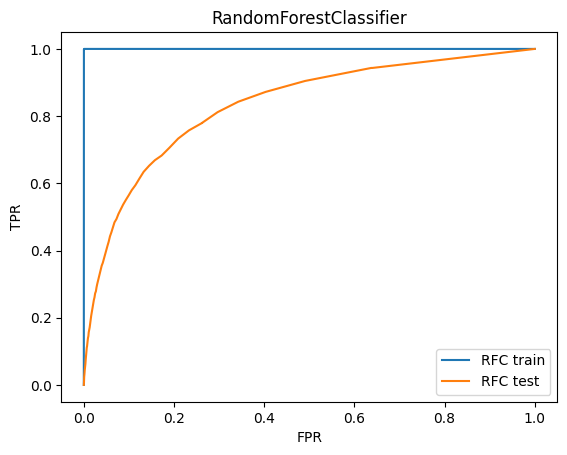

In [12]:
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_predicted_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_predicted_test)

plt.title('RandomForestClassifier')
plt.plot(fpr_train, tpr_train, label='RFC train')
plt.plot(fpr_test, tpr_test, label='RFC test')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [13]:
# Перекрестная оценка используя скоринг ROC_AUC
scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
scores

array([0.83010006, 0.82134785, 0.83709862, 0.81920141, 0.83122758])

### LogisticRegression

In [14]:
lr = LogisticRegression(max_iter=1000)                            
lr.fit(X_train, y_train);

y_predicted_train = lr.predict_proba(X_train)[:, 1]
y_predicted_test = lr.predict_proba(X_test)[:, 1]

print('AUC на обучающей выборке: {:.3f}'.
      format(metrics.roc_auc_score(y_train, y_predicted_train)))
print('AUC на тестовой выборке: {:.3f}'.
      format(metrics.roc_auc_score(y_test, y_predicted_test)))

AUC на обучающей выборке: 0.826
AUC на тестовой выборке: 0.826


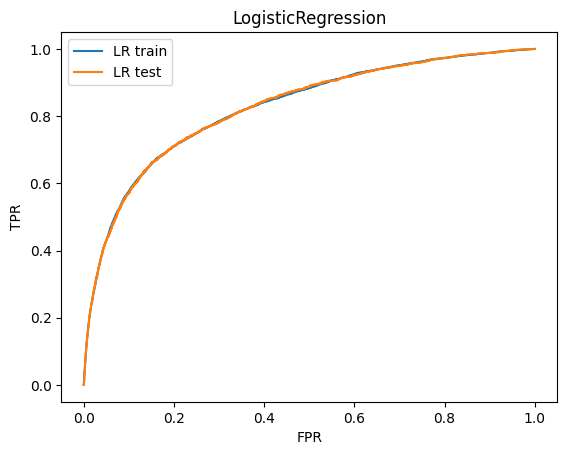

In [15]:
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_predicted_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_predicted_test)

plt.title('LogisticRegression')
plt.plot(fpr_train, tpr_train, label='LR train')
plt.plot(fpr_test, tpr_test, label='LR test')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()